In [27]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [28]:
from datetime import datetime, timedelta
from arch import arch_model
from statsmodels.graphics.tsaplots import plot_pacf

In [29]:
start_date = datetime(2013,1,1)
end_date = datetime(2022, 6, 1)

## Reading Stock data


In [30]:
symbol = 'AAPL'
apple_data = yf.Ticker(symbol)

In [31]:
prices = apple_data.history(start=start_date, end=end_date).Close

In [32]:
# multiplied by 100 to convert return to percent
daily_returns = 100 * (prices.pct_change().dropna())

Text(0, 0.5, 'Pct Returns')

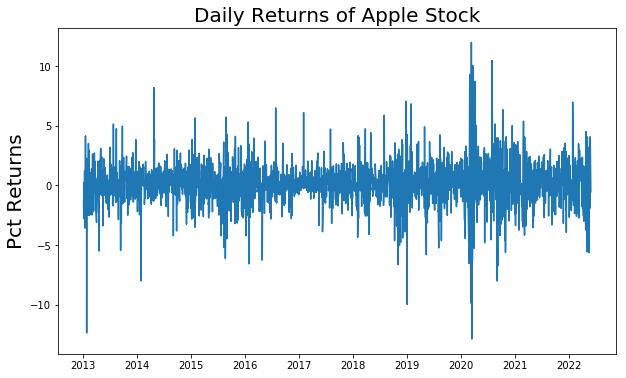

In [33]:
plt.figure(figsize=(10, 6))
plt.plot(daily_returns)
plt.title("Daily Returns of Apple Stock", fontsize=20)
plt.ylabel("Pct Returns", fontsize=20)

## It can be observed that returns are quite volatile, so, we can try to fit a Garch model in this return time series to find out or predict the volatility of returns tomorrow.

# Plot PACF on returns square time series to find out lag inclusion in volatility prediction model 

/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


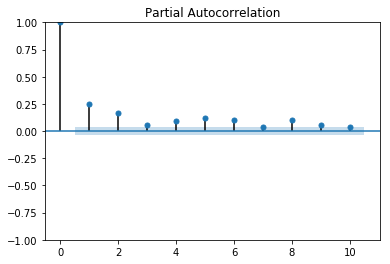

In [34]:
plot_pacf(daily_returns**2, lags=10)
plt.show()

## Many lags are significant but we will only include 2 lags to keep model simple and also PACF plot shuts off quite significantly after lag=2

In [38]:
model = arch_model(daily_returns, p = 2, q = 2)

In [39]:
model_fit = model.fit(disp='off')

In [40]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -4527.90
Distribution:                  Normal   AIC:                           9067.80
Method:            Maximum Likelihood   BIC:                           9102.43
                                        No. Observations:                 2369
Date:                Mon, Jul 18 2022   Df Residuals:                     2368
Time:                        15:10:13   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.1725  3.432e-02      5.026  5.020e-07 [  0.105,  0.240]
                              Volatility Model                             
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          0.3109      0.154      2.020  4.336e-02  [9.270e-03,  0.613]
alpha[1]       0.1207  4.113e-02      2.934  3.345e-03  [4.007e-02,  0.201]
alpha[2]       0.0850  4.838e-02      1.758  7.882e-02 [-9.793e-03,  0.180]
beta[1]        0.1030      0.688      0.150      0.881    [ -1.245,  1.451]
beta[2]        0.5959      0.573      1.039      0.299    [ -0.528,  1.720]
===========================================================================

Covariance estimator: robust
"""

## P values and Beta coefficients does not seems to be significant in the model fit, so, be